# Задание 2

## Задача 1

In [2]:
#import cvxopt as cp
#cp.solvers.options['show_progress'] = False

from scipy import optimize as opt
import time
import copy as cp
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

Найдем градиент и гессиан функции $f$:

$\frac {\partial f} {\partial x_1} = \frac {x_1 - 1} {2} + 8 x_1 (2 x_1^2 - x_2 - 1)$ 

$\frac {\partial f} {\partial x_n} = - 2(2 x_{n-1}^2 - x_n - 1)$

$\frac {\partial f} {\partial x_i} = 8 x_i (2 x_i^2 - x_{i+1} - 1) - 2(2 x_{i-1}^2 - x_i - 1),\ \ \ \ i = 2, ..., n - 1$

$$\frac{\partial^2 f}{\partial x_i \partial x_j} (x) =
\begin{pmatrix}
48 x_1^2 - 8 x_2 - 7.5 & -8 x_1 & 0 & ... & 0 & 0\\
-8 x_1 & 48 x_2^2 - 8 x_3 - 6 & -8 x_2 & ... & 0 & 0\\
0 & -8 x_2 & 48 x_3^2 - 8 x_4 - 6 & ... & 0 & 0\\
... & & & & & \\
0 & 0 & 0 & ... & 48 x_{n-1}^2 - 8 x_n - 6 & -8 x_{n-1} \\
0 & 0 & 0 & ... & -8 x_{n-1} & 2 \\
\end{pmatrix}$$

check_difference - функция, вычисляющая норму ошибки $\|x - x^*\|$, отклонение от оптимума $|f(x) - f(x^*)|$ и норму градиента $\|\nabla f(x)\|$:

In [4]:
def check_difference(func, grad_func, f_true, x, x_true):
    return np.linalg.norm(x - x_true), np.abs(func(x) - f_true), np.linalg.norm(grad_func(x)) 

Сама функция $f$ и её градиент и гессиан:

In [5]:
def func(x):
    l = len(x)
    res = 0
    res += (x[0] - 1)**2 / 4
    for i in range(1, l):
        res += (2 * x[i-1]**2 - x[i] - 1) ** 2
    return res

In [6]:
def grad_func(x):
    l = len(x)
    grad = np.zeros(l)
    grad[0] = 16*x[0]**3 - 8*x[0]*x[1] - 7.5*x[0] - 0.5
    grad[l-1] = -4*x[l-2]**2 + 2*x[l-1] + 2
    for i in range(1, l-1):
        grad[i] = 16*x[i]**3 - 4*x[i-1]**2 - 8*x[i]*x[i+1] - 6*x[i] + 2
    
    return grad

In [7]:
def hess_func(x):
    n = len(x)
    hess = np.zeros([n, n])
    hess[0,0] = 48*x[0]**2 - 8*x[1] - 7.5
    hess[0,1] = -8*x[0]
    hess[1,0] = hess[0,1]
    hess[n-1, n-1] = 2
    hess[n-1, n-2] = -8*x[n-2]
    hess[n-2, n-1] = hess[n-1, n-2]
    for i in range(1, n-1):
        hess[i, i] = 48*x[i]**2 - 8*x[i+1] - 6
        
        hess[i, i-1] = -8*x[i-1]
        hess[i, i+1] = -8*x[i+1]
        
        hess[i-1, i] = hess[i, i-1]
        hess[i+1, i] = hess[i, i+1]
    
    return np.matrix(hess)

Задаем размерность, генерируем $x$, задаем истинные значения минимума $x_{true}$, $y_{true}$.

In [8]:
dimension = 100
x = [-1.5] + [1.0]*(dimension - 1)

x_true = [1.0] * dimension
f_true = 0.0

Для случая $n=2$ нарисуем линии уровня функции $f$:

<a list of 221 text.Text objects>

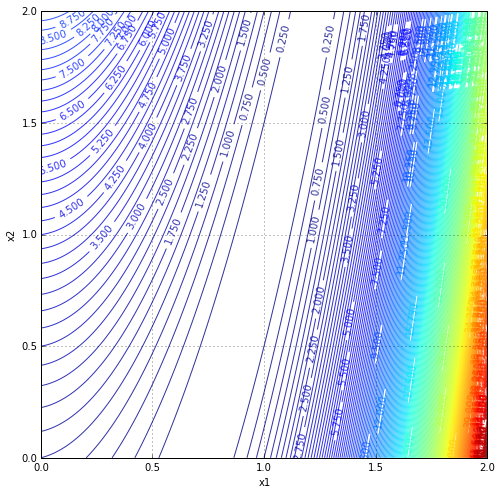

In [50]:
x1 = linspace(0, 2, 500)
x2 = linspace(0, 2, 500)
xx1, xx2 = meshgrid(x1, x2)

f = 0.25*(xx1 - 1)**2 + (2*xx1**2 - xx2 - 1)**2

constr3 = (xx2 <= -5)

figure(figsize=(8, 8))
grid(True)
xlabel('x1')
ylabel('x2')

CS = contour(x1, x2, f, 200, alpha=0.8)
plt.clabel(CS, CS.levels)

Имплеменатция метода градиентного спуска:

In [25]:
def gradient_descent(max_time=10, 
                     x0=x, 
                     func=func, 
                     x_true=x_true, 
                     f_true=f_true, 
                     grad_func=grad_func, 
                     hess_func=hess_func, 
                     check_difference=check_difference, 
                     tol=10**(-8)):
    start = time.time()
    log_f = list()
    log_grad_f = list()
    x = np.array(x0)
    step = 0.001
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 10 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1], log_f, log_grad_f]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1], log_f, log_grad_f]
        
        x -= step * grad_func(x)
        i += 1
        log_f.append(stats[1])
        log_grad_f.append(stats[2])

Имплементация метода сопряженных градиентов:

In [66]:
def conjugate_gradient(max_time=10, 
                       x0=x, 
                       func=func, 
                       x_true=x_true, 
                       f_true=f_true, 
                       grad_func=grad_func, 
                       hess_func=hess_func, 
                       check_difference=check_difference, 
                       tol=10**(-8)):
    start = time.time()
    log_f = list()
    log_grad_f = list()
    x = np.array(x0)
    i = 0
    S = -grad_func(x)
    new_grad = -S
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        
        if (i % 10 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1], log_f, log_grad_f]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1], log_f, log_grad_f]
        def func_lambd(lambd):
            return func(x + lambd * S)
        prev_grad = new_grad
        lambd = opt.minimize(func_lambd, 0.0, method='Powell').x
        x += lambd*S
        new_grad = grad_func(x)
        w = np.linalg.norm(new_grad)**2 / np.linalg.norm(prev_grad)**2
        S = -new_grad + w*S
        i += 1
        log_f.append(stats[1])
        log_grad_f.append(stats[2])

Имплементация метода наискорейшего спуска:

In [67]:
def optimal_gradient_descent(max_time=10, 
                             x0=x, 
                             func=func, 
                             x_true=x_true, 
                             f_true=f_true, 
                             grad_func=grad_func, 
                             hess_func=hess_func, 
                             check_difference=check_difference, 
                             tol=10**(-8)):
    start = time.time()
    log_f = list()
    log_grad_f = list()
    x = np.array(x0)
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 10 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1], log_f, log_grad_f]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1], log_f, log_grad_f]
        
        S = -grad_func(x)
        def func_lambd(lambd):
            return func(x + lambd * S)
        lambd = opt.minimize(func_lambd, 0.0, method='Powell').x
        x += lambd*S
        i += 1
        log_f.append(stats[1])
        log_grad_f.append(stats[2])

Имплементация метода Ньютона:

In [68]:
def newton_method(max_time=10, 
                  x0=x, 
                  func=func, 
                  x_true=x_true, 
                  f_true=f_true, 
                  grad_func=grad_func, 
                  hess_func=hess_func, 
                  check_difference=check_difference, 
                  tol=10**(-8)):
    start = time.time()
    log_f = list()
    log_grad_f = list()
    x = np.array(x0)
    i = 0
    while True:
        stats = check_difference(func, grad_func, f_true, x, x_true)
        if (i % 10 == 0):
            if (time.time() - start > max_time):
                return [0, x, i, stats[2], stats[0], stats[1], log_f, log_grad_f]
        if (stats[2] < tol):
            return [1, x, i, stats[2], stats[0], stats[1], log_f, log_grad_f]
        micro_step = 0.001
        S = grad_func(x)
        H = hess_func(x)
        res = H.I * np.matrix(S).T
        x -= np.asarray(res).ravel()
        i += 1
        log_f.append(stats[1])
        log_grad_f.append(stats[2])

Определим разумные размерности задач для различных методов:

In [36]:
dimension = 2000
x = [-1.5] + [1.0]*(dimension - 1)
x_true = [1.0] * dimension
f_true = 0.0
grad_descent = gradient_descent(10, x, func, x_true, f_true)
print grad_descent[0]

1


In [37]:
print grad_descent[2:6]

[1011, 9.9393125948000888e-09, 1.9654651017052425, 0.98303119852219689]


In [69]:
dimension = 10000
x = [-1.5] + [1.0]*(dimension - 1)
x_true = [1.0] * dimension
f_true = 0.0
conj_dec = conjugate_gradient(10, x, func, x_true, f_true)
print conj_dec[0]

1


In [44]:
print conj_dec[2:6]

[29, 6.3669642520462184e-09, 2.0741621500419431e-10, 6.3944668505979445e-19]


In [70]:
dimension = 12000
x = [-1.5] + [1.0]*(dimension - 1)
x_true = [1.0] * dimension
f_true = 0.0
opt_grad_desc = optimal_gradient_descent(10, x, func, x_true, f_true)
print opt_grad_desc[0]

1


In [51]:
print opt_grad_desc[2:6]

[25, 9.6879429414512716e-09, 3.7093142888476474e-10, 1.6145635716901406e-18]


In [71]:
dimension = 2
x = [-1.5] + [1.0]*(dimension - 1)
x_true = [1.0] * dimension
f_true = 0.0
new_meth = newton_method(10, x, func, x_true, f_true)
print new_meth[0]

1


In [62]:
print new_meth[2:6]

[6, 4.2721788994193929e-09, 5.1819626449952041e-10, 2.6840622056202491e-19]


В таблице приведены результаты работы четырех методов. Максимальное время было положено 10 секундам (5 минут ждать ну эт как-то не оч)

<table>
<tr>
<th>Метод</th>
<th>n</th>
<th>N</th>
<th>$\|\nabla f(x)\|$</th>
<th>$\|x - x^*\|$</th>
<th>$\|f(x) - f(x^*)\| $</th>
<th>Сошелся?</th>

</tr>
<tr>
<td>Градиентный спуск</td>
<td>$2000$</td>
<td>$1011$</td>
<td>$9.9 \cdot 10^{-9}$</td>
<td>$1.96$</td>
<td>$0.98$</td>
<td>Да</td>
</tr>

<tr>
<td>Сопряженных градиентов</td>
<td>$10000$</td>
<td>$29$</td>
<td>$6.3 \cdot 10^{-9}$</td>
<td>$2 \cdot 10^{-9}$</td>
<td>$6.3 \cdot 10^{-19}$</td>
<td>Да</td>
</tr>

<tr>
<td>Наискорейшего спуска</td>
<td>$12000$</td>
<td>$25$</td>
<td>$9.6 \cdot 10^{-9}$</td>
<td>$3.7 \cdot 10^{-10}$</td>
<td>$1.6 \cdot 10^{-18}$</td>
<td>Да</td>
</tr>

<tr>
<td>Ньютона</td>
<td>$2$</td>
<td>$6$</td>
<td>$4.2 \cdot 10^{-9}$</td>
<td>$5.1 \cdot 10^{-9}$</td>
<td>$2.6 \cdot 10^{-19}$</td>
<td>Да</td>
</tr>
</table>

Графики для разности $|f - f^*|$:

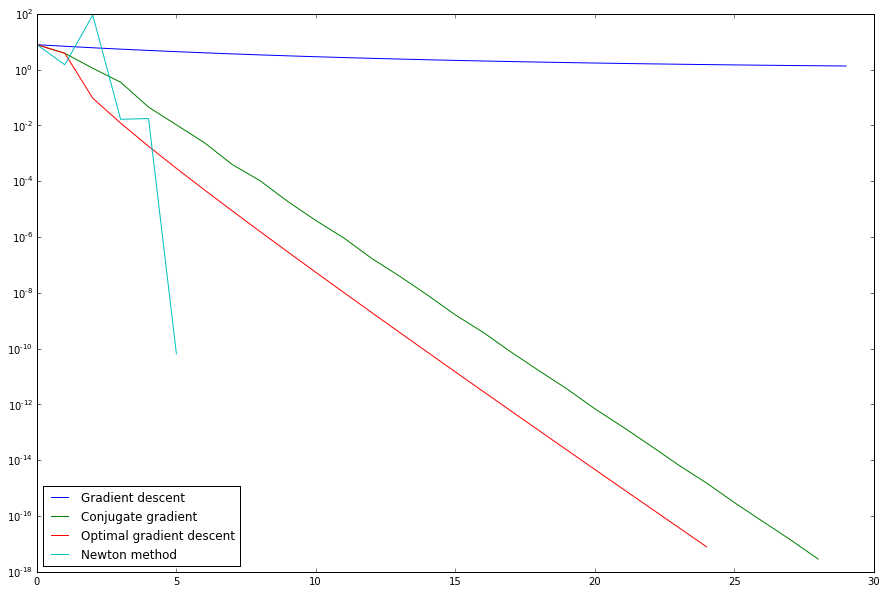

In [80]:
plt.figure(figsize=(15, 10))
plt.semilogy(grad_descent[6][:30], label='Gradient descent')
plt.semilogy(conj_dec[6], label='Conjugate gradient')
plt.semilogy(opt_grad_desc[6], label='Optimal gradient descent')
plt.semilogy(new_meth[6], label='Newton method')
plt.legend(loc='best')

Графики для $\|\nabla f\|$:

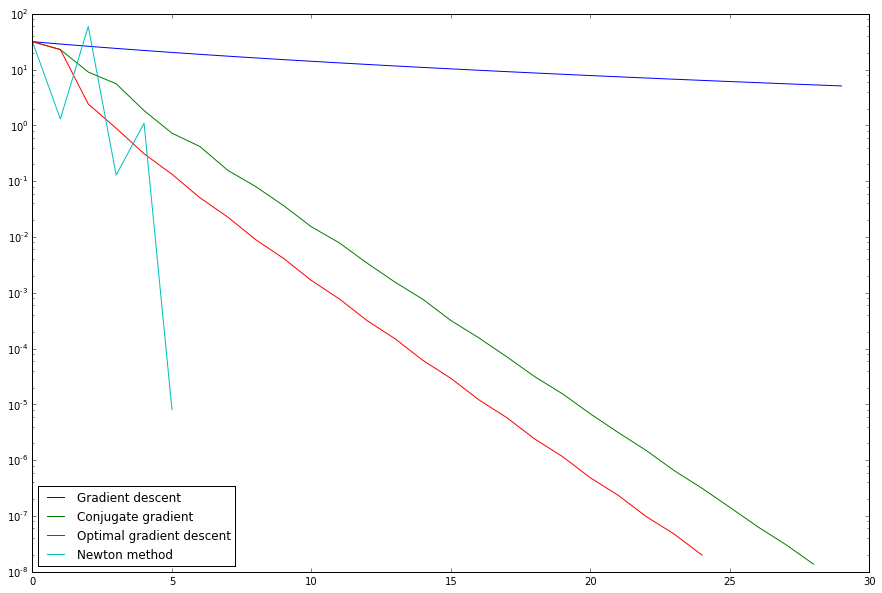

In [81]:
plt.figure(figsize=(15, 10))
plt.semilogy(grad_descent[7][:30], label='Gradient descent')
plt.semilogy(conj_dec[7], label='Conjugate gradient')
plt.semilogy(opt_grad_desc[7], label='Optimal gradient descent')
plt.semilogy(new_meth[7], label='Newton method')
plt.legend(loc='best')

## Задача 2

Градиент и гессиан функции, а так же точка оптимума и её значение:

$$ f(x) = \sum\limits_{i=1}^n e^{-x_i} + e^{\sum x_i - 1} $$

$$ \frac{\partial f}{\partial x_i} = - e^{-x_i} + e^{\sum x_i - 1} $$

$$ \frac{\partial^2 f}{\partial x_i \partial x_j} = e^{-x_i} \delta_{ij} + e^{\sum x_i - 1} $$

$$x_{i}^{opt} = \frac{1}{n+1}$$

$$f(x_{opt}) = (n+1) e^{- \frac{1}{n+1}}$$

Научимся генерировать "портящую" матрицу $P$. 

Нам нужна положительно определенная плохо обусловленная матрица с $\frac{\lambda_{max}}{\lambda_{min}} \sim 10^6$.

Создадим диагональную матрицу $D$, такую что $\frac{\max{D_{ii}}}{\min{D_{ii}}} \sim 10^6$. Затем умножим её на слева на $V$ и справа на $V^T$, где $V^T = V^{-1}$ - ортогональная матрица.

Ортогональную матрицу получим из QR разложения рандомной матрицы на ортогональную и верхнетреугольную.

После всего этого получим матрицу $P = VDV^T$, удовлетворяющую необходимым свойствам.

In [83]:
np.random.seed(2)
temp = np.random.randn(10000).reshape((100, 100))
Q, R = np.linalg.qr(temp)
P = Q.T.dot(np.diagflat([10**6] + [1]*99)).dot(Q)

Программная реализация:

In [84]:
def func2(x):
    return np.sum(np.power(np.e, -x)) + np.power(np.e, np.sum(x) - 1)

def bad_func2(x):
    return func2(P.dot(x))

def grad_func2(x):
    return - np.power(np.e, -x) + np.power(np.e, np.sum(x) - 1)

def bad_grad_func2(x):
    return P.dot(grad_func2(P.dot(x)))

def hess_func2(x):
    return np.matrix(np.diagflat(np.power(np.e, -x)) + np.power(np.e, np.sum(x) - 1))

def opt_x(dimension):
    return np.array([1.0 / (dimension+1)] * dimension)

def opt_func2(dimension):
    return func2(opt_x(dimension))

Реализация "плохой" функции:

In [85]:
dimension2 = 100
x2 = np.array(-np.random.randn(100)) / 1e7
bad_x2 = P.dot(x2)
bad_x2_opt = np.linalg.inv(P).dot(opt_x(100))
bad_func2_opt = bad_func2(bad_x2_opt)
print bad_x2.shape

(100L,)


In [98]:
conj_2 = conjugate_gradient(10, x2, func2, opt_x(100), opt_func2(100), grad_func2, hess_func2, check_difference, 10 ** (-6))
print conj_2[0]

1


In [99]:
grad_2 = gradient_descent(10, x2, func2, opt_x(100), opt_func2(100), grad_func2, hess_func2, check_difference, 10 ** (-6))
print grad_2[0]

1


In [102]:
opt_2 = optimal_gradient_descent(10, x2, func2, opt_x(100), opt_func2(100), grad_func2, hess_func2, check_difference, 10 ** (-6))
print opt_2[0]

1


In [104]:
new_2 = newton_method(10, x2, func2, opt_x(100), opt_func2(100), grad_func2, hess_func2, check_difference, 10 ** (-6))
print new_2[0]

1


Попробуем применить методы к плохой функции:

In [109]:
bad_conj_2 = conjugate_gradient(100, x2, bad_func2, bad_x2_opt, bad_func2_opt, bad_grad_func2, False, check_difference, 10 ** (-6))
print bad_conj_2[0]

0


C:\Users\rubik\Anaconda\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


In [110]:
bad_grad_2 = gradient_descent(10, x2, bad_func2, bad_x2_opt, bad_func2_opt, bad_grad_func2, False, check_difference, 10 ** (-6))
print bad_grad_2[0]

0


C:\Users\rubik\Anaconda\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app
C:\Users\rubik\Anaconda\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: overflow encountered in power
C:\Users\rubik\Anaconda\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in add
C:\Users\rubik\Anaconda\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
C:\Users\rubik\Anaconda\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in absolute
  from ipykernel import kernelapp as app
C:\Users\rubik\Anaconda\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in power


In [111]:
bad_opt_2 = optimal_gradient_descent(10, x2, bad_func2, bad_x2_opt, bad_func2_opt, bad_grad_func2, False, check_difference, 10 ** (-6))
print bad_opt_2[0]

0


C:\Users\rubik\Anaconda\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


Все очень плохо :)

Нарисуем таблицу и графики:

In [112]:
print conj_2[2:6]
print grad_2[2:6]
print opt_2[2:6]
print new_2[2:6]

[3, 9.2187848896399074e-07, 8.8488625761804194e-07, 3.979039320256561e-13]
[163, 9.8963115803374512e-07, 7.821031011890817e-07, 2.9842794901924208e-13]
[2, 9.3021166063730775e-07, 8.9592385627260729e-07, 3.979039320256561e-13]
[5, 8.4895357044256762e-08, 8.4891168452428293e-10, 1.4210854715202004e-14]


<table>
<tr>
<th>Метод</th>
<th>N</th>
<th>$\|\nabla f(x)\|$</th>
<th>$\|x - x^*\|$</th>
<th>$\|f(x) - f(x^*)\| $</th>

</tr>
<tr>
<td>Градиентный спуск</td>
<td>$163$</td>
<td>$9.8 \cdot 10^{-7}$</td>
<td>$7.8 \cdot 10^{-7}$</td>
<td>$2.9 \cdot 10^{-13}$</td>
</tr>

<tr>
<td>Сопряженных градиентов</td>
<td>$3$</td>
<td>$9.21 \cdot 10^{-7}$</td>
<td>$8.8 \cdot 10^{-7}$</td>
<td>$3.9 \cdot 10^{-13}$</td>
</tr>

<tr>
<td>Наискорейшего спуска</td>
<td>$2$</td>
<td>$9.3 \cdot 10^{-7}$</td>
<td>$8.9 \cdot 10^{-7}$</td>
<td>$3.9 \cdot 10^{-13}$</td>
</tr>

<tr>
<td>Ньютона</td>
<td>$5$</td>
<td>$8.4 \cdot 10^{-8}$</td>
<td>$8.4 \cdot 10^{-10}$</td>
<td>$1.4 \cdot 10^{-14}$</td>
</tr>
</table>

Графики для разности $|f - f^*|$:

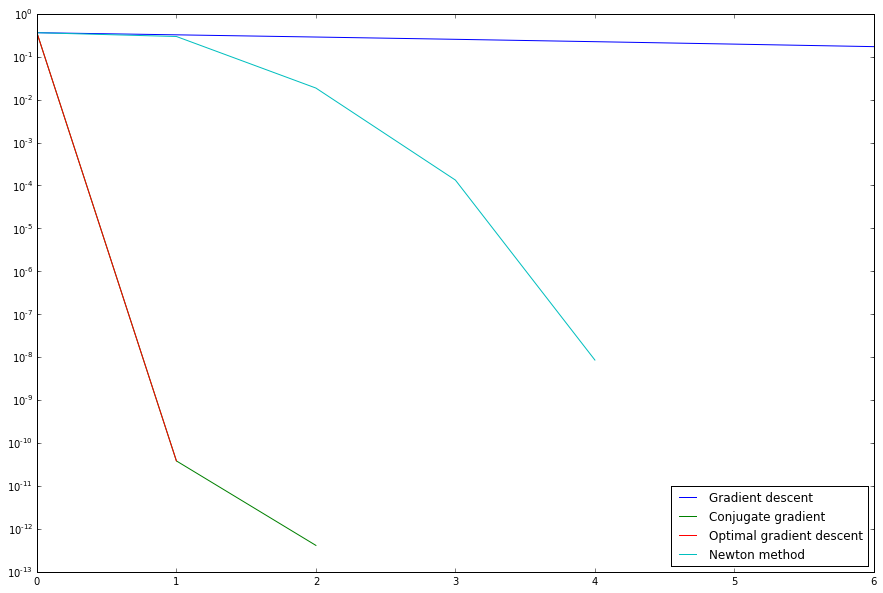

In [114]:
plt.figure(figsize=(15, 10))
plt.semilogy(grad_2[6][:7], label='Gradient descent')
plt.semilogy(conj_2[6], label='Conjugate gradient')
plt.semilogy(opt_2[6], label='Optimal gradient descent')
plt.semilogy(new_2[6], label='Newton method')
plt.legend(loc='best')

Графики для $\|\nabla f\|$:

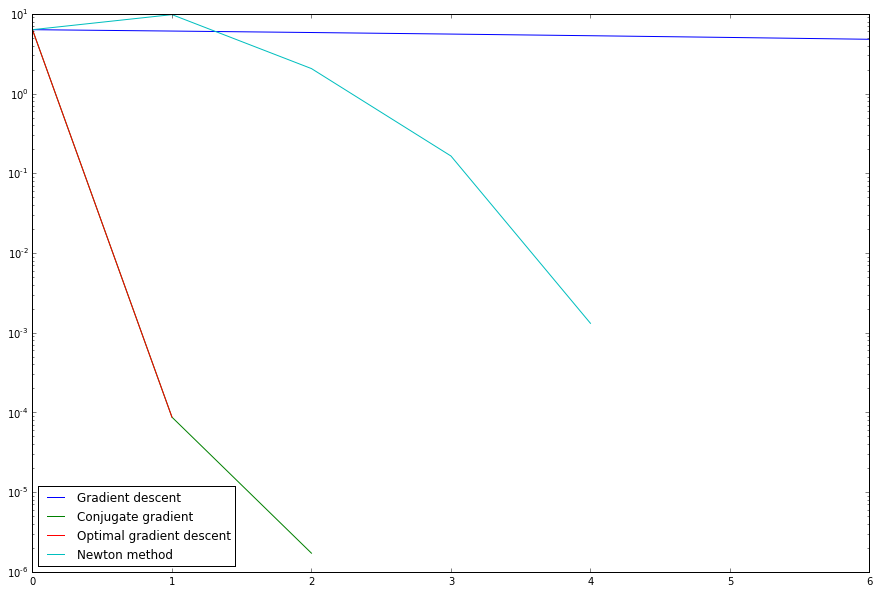

In [116]:
plt.figure(figsize=(15, 10))
plt.semilogy(grad_2[7][:7], label='Gradient descent')
plt.semilogy(conj_2[7], label='Conjugate gradient')
plt.semilogy(opt_2[7], label='Optimal gradient descent')
plt.semilogy(new_2[7], label='Newton method')
plt.legend(loc='best')